In [1]:
import os
import pandas as pd
from fastai.vision.all import *
from fastai.vision import models
from fastai.metrics import error_rate, accuracy

import warnings
warnings.filterwarnings('ignore')
set_seed(42)


# Data Preprocessing

#### Read data and store it in dataframe

In [2]:
#Generate data paths with labels
data_dir = '/kaggle/input/weather-dataset/dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
# Conatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries,Lseries],axis=1)

In [3]:
df

,filepaths,labels
0,/kaggle/input/weather-dataset/dataset/hail/0106.jpg,hail
1,/kaggle/input/weather-dataset/dataset/hail/0375.jpg,hail
2,/kaggle/input/weather-dataset/dataset/hail/0285.jpg,hail
3,/kaggle/input/weather-dataset/dataset/hail/0074.jpg,hail
4,/kaggle/input/weather-dataset/dataset/hail/0077.jpg,hail
...,...,...
6857,/kaggle/input/weather-dataset/dataset/dew/2689.jpg,dew
6858,/kaggle/input/weather-dataset/dataset/dew/2607.jpg,dew
6859,/kaggle/input/weather-dataset/dataset/dew/2691.jpg,dew
6860,/kaggle/input/weather-dataset/dataset/dew/2867.jpg,dew


In [4]:
dls = ImageDataLoaders.from_df(df,
                                fn_col=0, # filepaths
                                label_col=1, # labels
                                valid_pct=0.2,
                                folder='/', 
                                item_tfms=Resize(224))

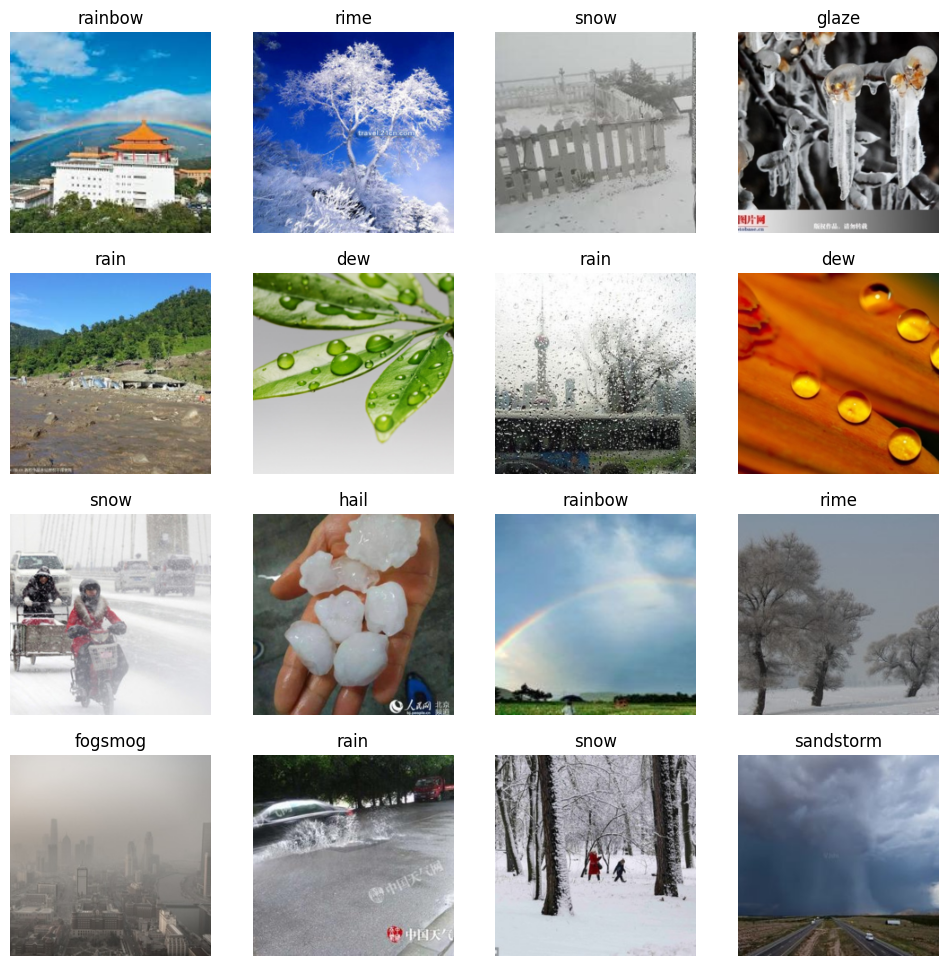

In [5]:
dls.show_batch(max_n=16)

# Model Structure

In [6]:
model = vision_learner(dls, 'efficientnet_b3',
                       metrics=[accuracy,error_rate], path='.').to_fp16()

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

In [7]:
model.summary()

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 40 x 112 x 112 
Conv2d                                    1080       False     
Identity                                                       
SiLU                                                           
Conv2d                                    360        False     
Identity                                                       
SiLU                                                           
Identity                                                       
____________________________________________________________________________
                     64 x 10 x 1 x 1     
Conv2d                                    410        False     
SiLU                                                           
____________________________________________________________________________
                     64 x 40 x 1 x 1     
Conv2d                             

## Training

In [8]:
model.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.298689,1.057678,0.669096,0.330904,00:36
1,1.238514,0.659531,0.790816,0.209184,00:28
2,0.812824,0.524582,0.838192,0.161808,00:28
3,0.624029,0.525165,0.839650,0.160350,00:28
4,0.500955,0.492997,0.842566,0.157434,00:28
5,0.391882,0.451500,0.855685,0.144315,00:27
6,0.333464,0.450210,0.853499,0.146501,00:28
7,0.293626,0.439631,0.865160,0.134840,00:28
8,0.251119,0.430344,0.870262,0.129738,00:28
9,0.222845,0.432999,0.875364,0.124636,00:28


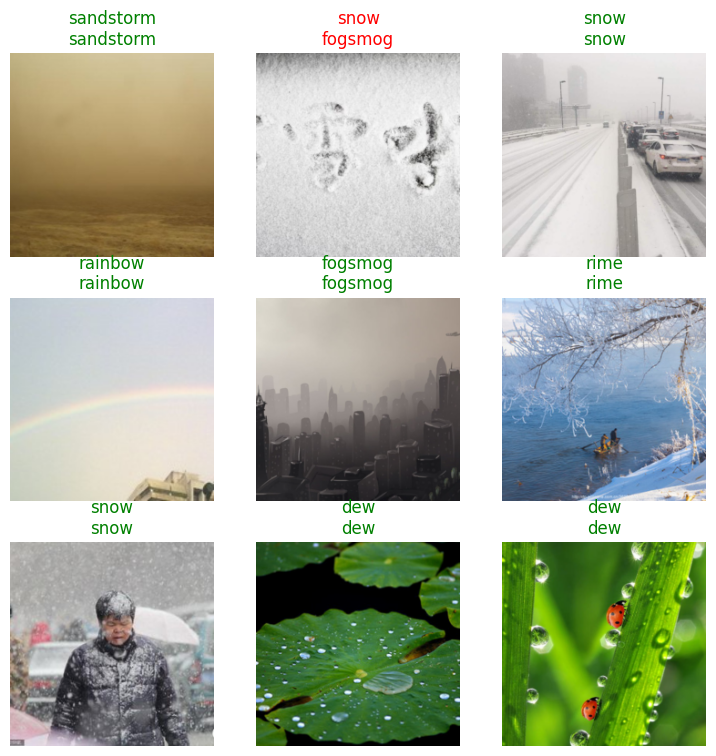

In [9]:
model.show_results()

In [13]:

val_loss, val_acc, val_err = model.validate()  # Unpack three values
print(f"Validation accuracy: {val_acc:.4f}")
print(f"Validation error rate: {val_err:.4f}")

Validation accuracy: 0.8921
Validation error rate: 0.1079


In [16]:
# Build a Classification Interpretation object from our learn model
# it can show us where the model the worse predictions:
CI= ClassificationInterpretation.from_learner(model)

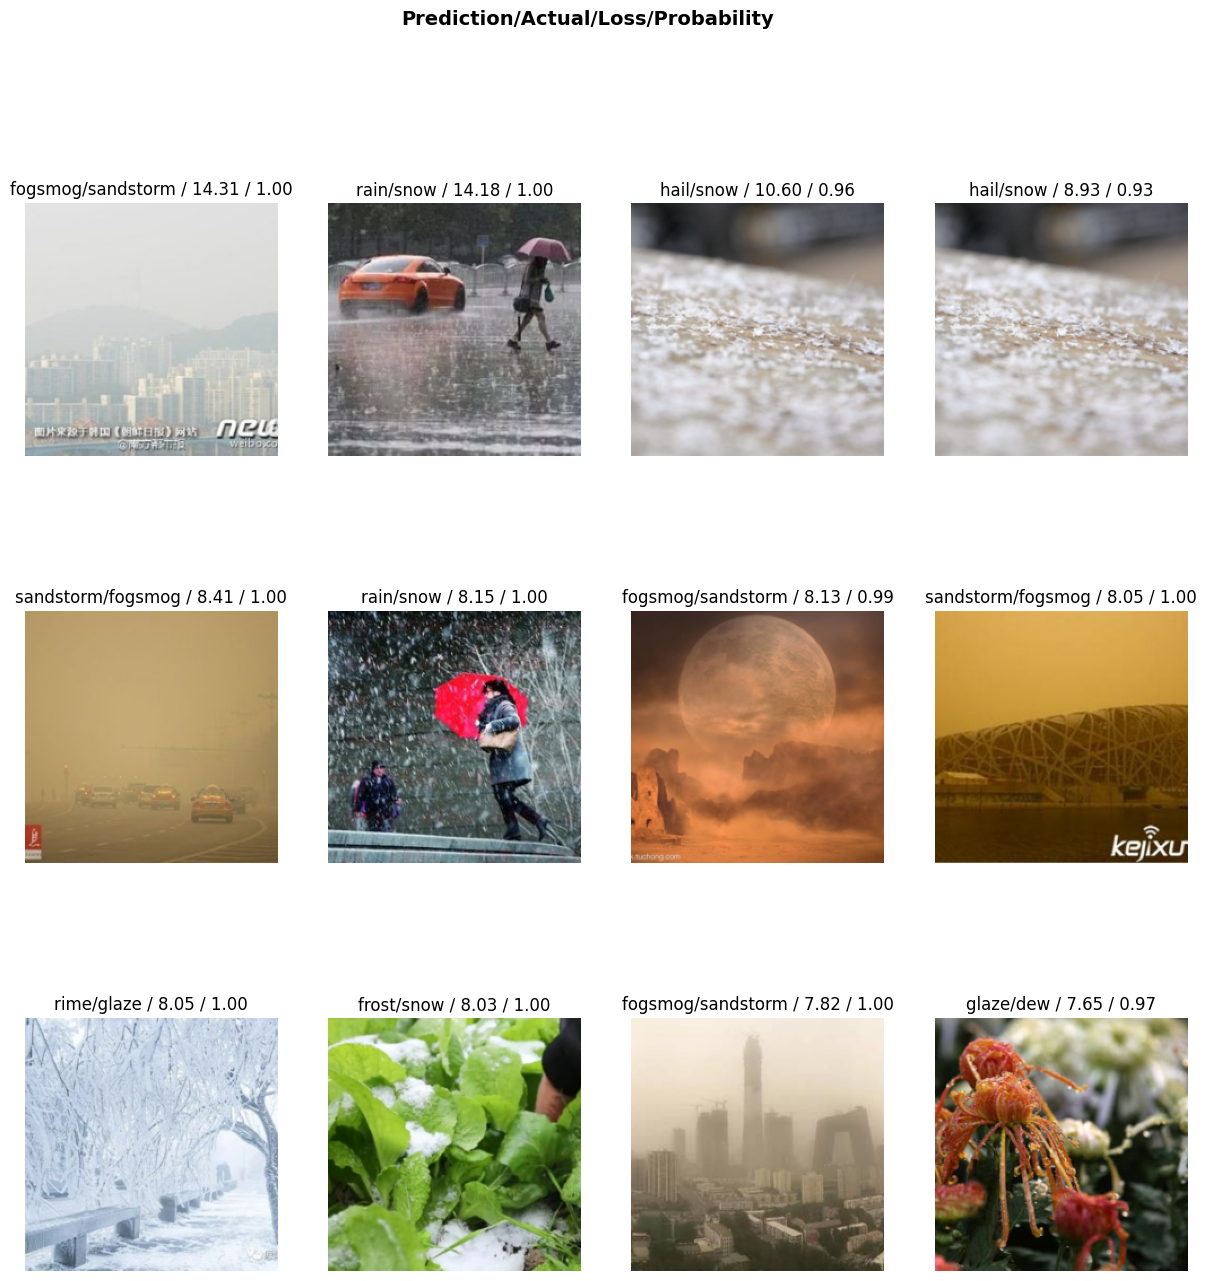

In [17]:
# Plot the top 'n' classes where the classifier has least precision.
CI.plot_top_losses(12, figsize=(15,15))

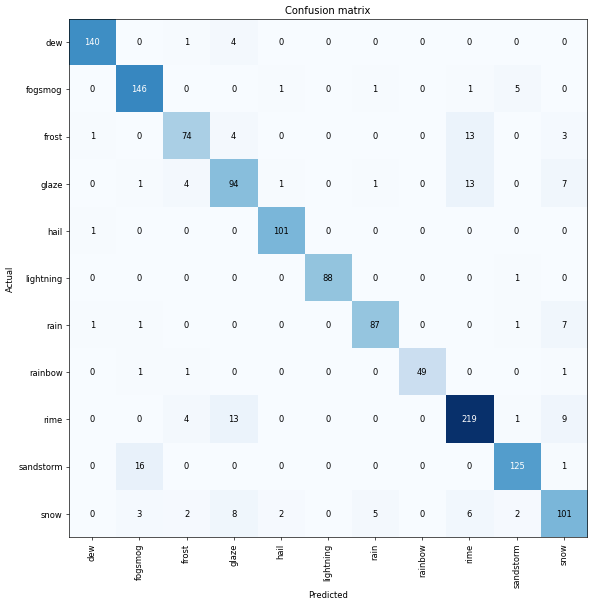

In [18]:
CI.plot_confusion_matrix(figsize=(10,10),dpi=60)

In [20]:
#To view the list of classes most misclassified as a list
CI.most_confused(min_val=2) #We are ignoring single image misclassification

#Sorted descending list of largest non-diagonal entries of confusion matrix, 
#presented as actual, predicted, number of occurrences.


[('sandstorm', 'fogsmog', 16),
 ('frost', 'rime', 13),
 ('glaze', 'rime', 13),
 ('rime', 'glaze', 13),
 ('rime', 'snow', 9),
 ('snow', 'glaze', 8),
 ('glaze', 'snow', 7),
 ('rain', 'snow', 7),
 ('snow', 'rime', 6),
 ('fogsmog', 'sandstorm', 5),
 ('snow', 'rain', 5),
 ('dew', 'glaze', 4),
 ('frost', 'glaze', 4),
 ('glaze', 'frost', 4),
 ('rime', 'frost', 4),
 ('frost', 'snow', 3),
 ('snow', 'fogsmog', 3),
 ('snow', 'frost', 2),
 ('snow', 'hail', 2),
 ('snow', 'sandstorm', 2)]